### ASTR 8070: Astrostatistics
***N. Pol***
___

# Homework 6
### Due: Saturday, Mar 14th at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [2]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity, NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats


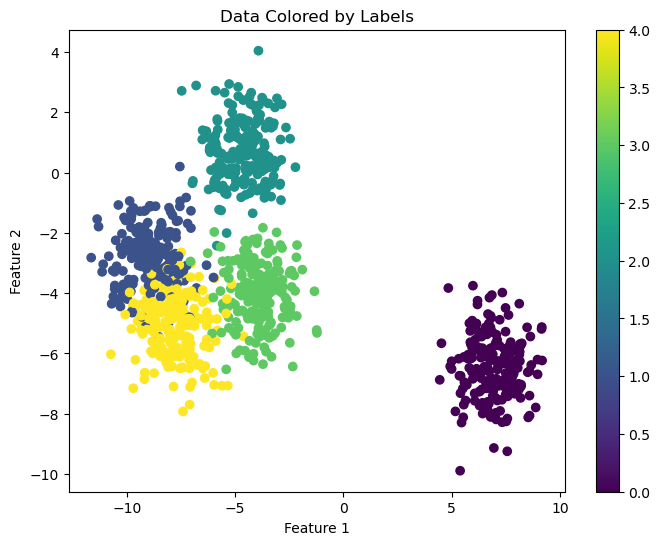

In [7]:
# Part 1
data = np.load('C:/Users/jeell/OneDrive/Documents/GitHub/ASTR_3300_S2025/coursework/homeworks/hw_data/hw6_data_1.npy')
feat = data[:, :2]
labels = data[:, 2]

plt.figure(figsize=(8,6))
plt.scatter(feat[:, 0], feat[:, 1], c = labels, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data Colored by Labels')
plt.colorbar()
plt.show()

Best Bandwidth: 0.4724137931034482


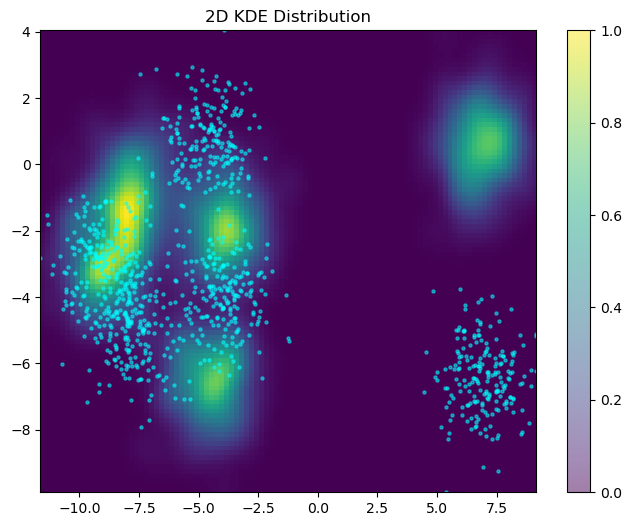

In [15]:
# Part 2
bandwidths = np.linspace(0.1, 1.0, 30)
grid = GridSearchCV(KernelDensity(), {'bandwidth': bandwidths}, cv=KFold(n_splits=5))
grid.fit(feat)

b_b = grid.best_params_['bandwidth']
print(f"Best Bandwidth: {b_b}")

kde = KernelDensity(bandwidth = b_b).fit(feat)

x_grid, y_grid = np.mgrid[feat[:, 0].min():feat[:, 0].max():100j, feat[:,1].min():feat[:, 1].max():100j]
p = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
d = np.exp(kde.score_samples(p)).reshape(x_grid.shape)
plt.figure(figsize=(8,6))
plt.imshow(np.rot90(d), extent=[feat[:, 0].min(), feat[:, 0].max(), feat[:, 1].min(), feat[:, 1].max()], aspect='auto', origin='lower', cmap='viridis')
plt.scatter(feat[:, 0], feat[:, 1], s=5, c='cyan', alpha=0.5)
plt.colorbar()
plt.title('2D KDE Distribution')
plt.show()


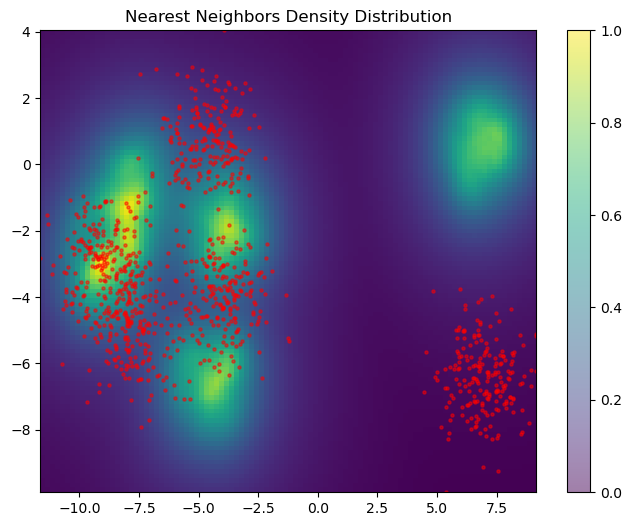

In [17]:
# Part 3
nn = NearestNeighbors(n_neighbors=50)
nn.fit(feat)
dist, ind = nn.kneighbors(feat)
den_nn = 1 / np.mean(dist, axis=1)
x_grid, y_grid = np.mgrid[feat[:, 0].min():feat[:, 0].max():100j, feat[:, 1].min():feat[:, 1].max():100j]
pos = np.vstack([x_grid.ravel(), y_grid.ravel()]).T
den_nn_grid = np.zeros(pos.shape[0])

for i, po in enumerate(pos):
    dist, ind = nn.kneighbors([po])
    den_nn_grid[i] = 1 / np.mean(dist)
den_nn_grid = den_nn_grid.reshape(x_grid.shape)

plt.figure(figsize=(8,6))
plt.imshow(np.rot90(den_nn_grid), extent=[feat[:, 0].min(), feat[:, 0 ].max(), feat[:, 1].min(), feat[:, 1].max()], aspect='auto', origin='lower', cmap='viridis')
plt.scatter(feat[:, 0], feat[:, 1], s=5, c='red', alpha=0.5)
plt.colorbar()
plt.title('Nearest Neighbors Density Distribution')
plt.show()


In [ ]:
# Part 4
n_components = np.arange(1, 11)
aics = []
bics = []

for n in n_components:
    gmm = GaussianMixture(n_components=n).fit(feat)
    aics.append(gmm.aic(feat))
    bics.append(gmm.bic(feat))

plt.figure(figsize=(8,6))
plt.plot(n_components, aics, label='AIC', color='cyan')
plt.plot(n_components, bics, label='BIC', color='green')
plt.xlabel('Number of Components')
plt.ylabel('AIC/BIC')
plt.title('Number of Components vs. AIC and BIC')
plt.legend()
plt.show()

opt_n = n_components[np.argmin(bics)]
print(f"Optimal Number of GMM Components (BIC): {opt_n}")

gmm_opt = GaussianMixture(n_components=opt_n).fit(feat)
means = gmm_opt.means_
covar = gmm_opt.covariances_

def plot_cov_ell(cov, mean, ax, nstd=2, **kwargs):
    pearson = cov[0,1] / np.sqrt(cov[0,0] * cov[1,1])
    ell_rad_x = np.sqrt(1+pearson)
    ell_rad_y = np.sqrt(1-pearson)
    ell = plt.matplotlib.patches.Ellipse((0,0), width=ell_rad_x*2, height=ell_rad_y*2, facecolor='none', **kwargs)
    scale_x = np.sqrt(cov[0,0])*nstd
    scale_y = np.sqrt(cov[1,1])*nstd
    transf = plt.matplotlib0.transform.Affine2D().rotate_deg(45).scale(scale_x, scale_y).translate(mean[0], mean[1])
    ell.set_transform(transf + ax.transData)
    return ax.add_patch(ell)

plt.figure(figsize=(8,6))
plt.scatter(feat[:, 0], feat[:, 1], c=labels, cmap='viridis')
for i in range(opt_n):
    
    